# Guide to Wonky


In [1]:
%matplotlib inline
import wonky

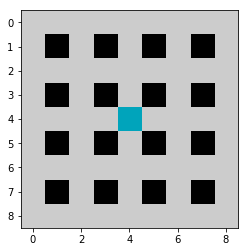

In [83]:
#list for trace, list for active flag, list for species count per site - capped, list for active particles of type
#reactions later will have a fast function that validates a reaction and then we choose one of viable by proportionate rate
import numpy as  np
from numba import jit

class crn(object):
    def __init__(self,reaction_system, lattice_size, ICs = [], options={}):
        self._num_species = len(reaction_system[1])
        self._rsys = reaction_system
        self._lattice_size = lattice_size
        self._ics = ICs
        self._max_time_units = 10# from options
            
        num_observables, num_increments = 2,10
        #self.statistics =  statistics((self._num_species,num_observables,num_increments))     
        self.__reset__()
                  
    def __reset__(self,params={}): 
        self._lattice_map = wonky.lattice.get_hyper_lattice(*self._lattice_size)
        self._trace_map = wonky.lattice.get_hyper_lattice(*self._lattice_size)
        self._lattice_sites = wonky.lattice.get_species_counter(*self._lattice_size,self._num_species)  
        self._trace_delta_template = np.zeros((self._num_species))
        #for performance/simplicity we cheat with the data structure - last two locations are for meta data, count and last-sampled-address
        self._active_sites = np.zeros(len(self._trace_map)+2,np.int)  
        site = int(len(self._lattice_sites)/2)
        for i,s in enumerate(self._ics):
            self.put(site,i)
            #put as many species as we init with on this site
            self._lattice_sites[site][i] = s
        
        #self.statistics.init()
            
    def __repr__(self):
        return "{} species, {} reactions on a {} lattice".format(self._num_species,len(self._rsys[-1]),self._lattice_size)
       
    #for these maybe i can do multi species in a grid of subplots
    def display_lattice(self,species=0):
        species = 0
        wonky.plotting.grid_display(self._lattice_map,0)
        
    def display_trace(self,species=0):
        species = 0
        wonky.plotting.grid_display(self._trace_map,0)
        
    def lattice_sites(self):
        import pandas as pd
        return pd.DataFrame(self._lattice_sites)
    
    def run_experiment(self, ex_options):
        for params in range(ex_options.parameter_space):
            stats,lattice,trace = self.sample(params) 
    
    #####################
    ###Begin manage active sites
    #####################
    
    def __active_site_enter__(i,lattice_map, active_sites):
         #site tracking - if we are adding something for the first time, add to active sites
        if lattice_map[i] == 0:
            active_sites[active_sites[-1]] = i
            active_sites[-1] +=1
            
    def __active_site_exit__(i,lattice_map, active_sites):
        #check on visiting site if we are first
        if lattice_map[i] == 0:
            active_sites[active_sites[-2]] =  active_sites[active_sites[-1] - 1]
            active_sites[-1]-=1

    def sample_active_site(self):
        #pick any active site
        r = np.random.randint(self._active_sites[-1])
        #record wich one we sampled to manage stack
        self._active_sites[-2] = r
        return r
    
    #####################
    ###End manage active sites
    #####################
    
    #####################
    ###Begin graph interaction
    #####################
    
    def put(self,i,s):
        self._trace_delta_template[:] = 0     
        crn.__put__(i,s,self._trace_delta_template, self._lattice_map, self._trace_map, self._lattice_sites, self._active_sites)
        return self._trace_delta_template
        
    def __put__(i,s, trace_delta, lattice_map, trace_map, lattice_sites,active_sites): 
        #puts will mostly be from diffusing to another site but sometimes reactions will put items on existing sites - optimize?
        crn.__active_site_enter__(i,lattice_map, active_sites)
        wonky.lattice.put(lattice_map, i, s)
        lattice_sites[i][s]+=1
        if wonky.lattice.get(trace_map, i, s) == 0:
            wonky.lattice.put(trace_map, i, s)
            trace_delta[s]+=1
        
    def remove(self,i,s):
        d = crn.__remove__(i,s,self._trace_delta_template,self._lattice_map, self._trace_map, self._lattice_sites)
        return d
        
    def __remove__(i,s, trace_delta, lattice_map, trace_map, lattice_sites,active_sites):    
        if wonky.lattice.get(lattice_map, i, s) != 0:#check if exists  
            lattice_sites[i][s] -= 1 #decrement
            if lattice_sites[i][s] == 0: #if i am the last of my kind, remove flag
                wonky.lattice.remove(lattice_map, i, s)
            return 1
        return 0
    
    #####################
    ###End graph interaction
    #####################

    #####################
    ###Primary CRN functions
    #####################

    def sample(self,params):
        self.__reset__(params)
        while self._t < self._max_time_units and self._active_site_count > 0:         
            i = self.sample_active_site()
            delta = crn.__reaction_diffusion_sampler__(i,self._rsys, self._lattice_sites)
            trace_delta = crn.__update_sites__(i,delta, 
                                               self._lattice_map, 
                                               self._trace_map, 
                                               self._lattice_sites, 
                                               self._active_sites,
                                               self._lattice_size[0]
                                              )
            crn.__active_site_exit__(site, net._lattice_map,net._active_sites)
            self.statistics.update(self._t, [delta, trace_delta])
        self.statistics.flush()
        
    def __update_sites__(i, delta, lattice_map, trace_map, lattice_sites, active_sites, length, dim=2):  
        trace_delta = np.zeros(len(delta))
        lattice_site = lattice_sites[i]
        for s, c in enumerate(delta):
            if c > 0:#case positive changes for species
                crn.__put__(i,s, trace_delta, lattice_map, trace_map,lattice_sites,active_sites)
                idash = wonky.lattice.diffuse(i, length, dim)
                crn.__remove__(i,s, trace_delta, lattice_map, trace_map,lattice_sites,active_sites)
                crn.__put__(idash,s, trace_delta, lattice_map, trace_map,lattice_sites,active_sites) 
            if c < 0:
                crn.__remove__(i,s, trace_delta, lattice_map, trace_map,lattice_sites,active_sites)    
        return trace_delta

    def __reaction_diffusion_sampler__(i, rsystem, lattice_sites):
        sys = rsystem[0]
        #only reactions for which there are sufficient particles at sites can happen
        mask = np.all((lattice_sites[i]-sys[:,:,0]  >= 0) ,axis=1)
        viable_subsystem = sys[mask]
        rates = rsystem[-1][mask]
        rates /= rates.sum()
        #choose a reaction from the viable subsystem according to the rates
        choice = np.random.choice(len(rates),1,p=rates)[0]
        choice = viable_subsystem[choice]
        delta = -choice[:,0] + choice[:,1]    
        return delta#,trace delta on any site
        
            
rsys =  wonky.reaction.reaction_system([wonky.reaction("A", "A+A", 0.5),
                                        wonky.reaction("A", "0", 0.5)])

net = crn(rsys, (9,2), ICs=[1])
net.display_lattice(0)

In [82]:
net._active_sites
#net.sample_active_site()

array([40,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1])

In [75]:
delta = crn.__reaction_diffusion_sampler__(site, net._rsys, net._lattice_sites)
delta

array([1])

In [76]:
#simulate sampling the first site - possible inconsistency here - assumtions going in is that site is active!
crn.__update_sites__(site,delta, net._lattice_map, net._trace_map, net._lattice_sites, net._active_sites,9)
net._active_sites

array([40, 39,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2])

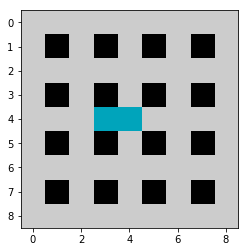

In [77]:
net.display_lattice(0)

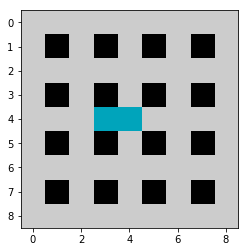

In [78]:
net.display_trace(0)

In [79]:
net.lattice_sites()[35:50]

,0
35,0
36,0
37,0
38,0
39,1
40,1
41,0
42,0
43,0
44,0


In [ ]:
from numba import jit
import numpy as np
class experiment_options(dict):
    pass

class statistics(np.ndarray):   
    def __new__(subtype, shape, dtype=float ):
        size = list(shape)
        size.insert(2,9)
        obj = super(statistics, subtype).__new__(subtype, size, dtype)  
        obj._num_species = size[0]
        obj._num_obs = size[1]
        obj._num_moments = size[-2]
        obj._num_increments = size[1]
        obj._last_t = 0
        obj[:] = 0 
        return obj

    def __init__(self, *args):
        pass
        
    def init():
        #and do flush check
        return self

    def save(self, file=None):
        #fastest way to dump the page to disk in a way pandas will be able to get it back
        #could put it on another thread and get on with the next chunk but whatever
        pass
    
    @jit
    def update(self, t, v):
        #convert v from a bit species delta to a counter update
        #we have our own internal counter for all t
        #if capturing, do the next bit
        self._last_t = t
        for o in range(self._num_obs):
            for s in range(self._num_species):
                for m in range(self._num_moments):   
                    self[s][o][m][t] = v[s][o]**m
                
    @jit
    def flush(self):
        for o in range(self._num_obs):
            for s in range(self._num_species):
                for m in range(self._num_moments):
                    ar = self[s][o][m]
                    val = ar[self._last_t]
                #then fill all nan values with this last computed value 
                    self[s][o][m] = val            
        self.save()
                
    
#stats module time loop test
#create a numpy tensor wrapper with functions and make it avaialble to another object which is itself fast

 

In [ ]:
S = statistics((1,2,10))
S.shape

In [ ]:
v = [[13,12]]
S.update(0, v)

In [ ]:
S.flush()
S.astype(int)

In [ ]:
#Tests
#1. active site sampling and replacing
#2. subsystem sampling
#3. state management i.e. delta updates on sites

In [ ]:
size = (100,2)
L = get_hyper_lattice(*size)
walk_lattice_from(L,size)
display(L,size[-1],1)